# Collective Quantum Exhaustive Search Experiments
These are defiend by the instructions in an email from 13.2.24 from IA to DM and TM.

## Used external notebooks

In [1]:
from ipynb.fs.full.ansatz import get_twolocal

### Imports

In [2]:
from qiskit.quantum_info import SparsePauliOp
import networkx as nx
import random

from hamiltonians import gen_trans_ising_op, get_exact_ground, gen_maxcut_op, gen_maxcut_op_from_graph
from experiment_utils import *
from graphing import plot_VQE_evals_list

random.seed(7)

## Two-qubit experiments
These experiments are run on two types of examples:
-   Molecular Hamiltonians: H2 and HeH.
-   Transverse-Field Ising Model Hamiltonians.

For these, we will present:
-   The energy landscape sampled using all MUB states (without an appended ansatz).
-   VQE execution from the best 10 MUB states as initial points (awaiting Dekel's code to do this).

### Hamiltonian Generation

In [3]:
H2_ham_0_75 = SparsePauliOp(data= ['II', 'IZ', 'ZI', 'ZZ', 'XX'],
coeffs= [-1.06324002+0.j,  0.38913654+0.j, -0.38913654+0.j, -0.01121274+0.j,  0.18206025+0.j])

HeH_ham_1 = SparsePauliOp(data= ['II', 'IZ', 'IX', 'ZI', 'XI', 'ZZ', 'ZX', 'XZ', 'XX'],
coeffs= [-3.04506092+0.j,  0.50258052+0.j,  0.11926278+0.j, -0.50258052+0.j, 0.11926278+0.j, -0.13894646+0.j, -0.11926145+0.j,  0.11926145+0.j,  0.11714671+0.j])

molecular_hams = [H2_ham_0_75, HeH_ham_1]
molecular_descs = ["LiH, 0.75A, 2 qubits", "HeH, 1A, 2 qubits"]

transverse_hams = [gen_trans_ising_op(2, random.uniform(0,1), random.uniform(0,1)) for _ in range(2)]

### Calculate Landscape

===Calculating Molecular Landscapes===
attempting all MUB states over the operator SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.06324002+0.j,  0.38913654+0.j, -0.38913654+0.j, -0.01121274+0.j,
  0.18206025+0.j])
Energy Landscape:


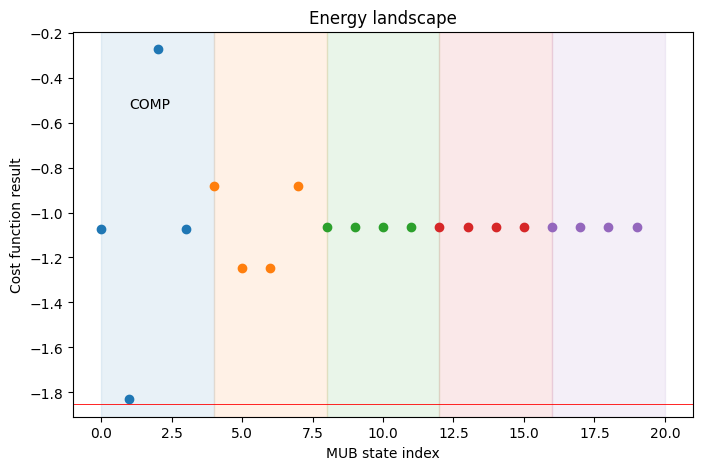

Energy Histogram:


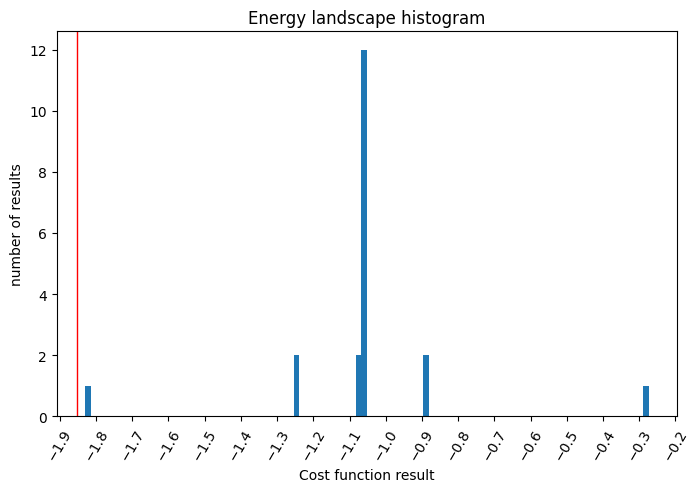

attempting all MUB states over the operator SparsePauliOp(['II', 'IZ', 'IX', 'ZI', 'XI', 'ZZ', 'ZX', 'XZ', 'XX'],
              coeffs=[-3.04506092+0.j,  0.50258052+0.j,  0.11926278+0.j, -0.50258052+0.j,
  0.11926278+0.j, -0.13894646+0.j, -0.11926145+0.j,  0.11926145+0.j,
  0.11714671+0.j])
Energy Landscape:


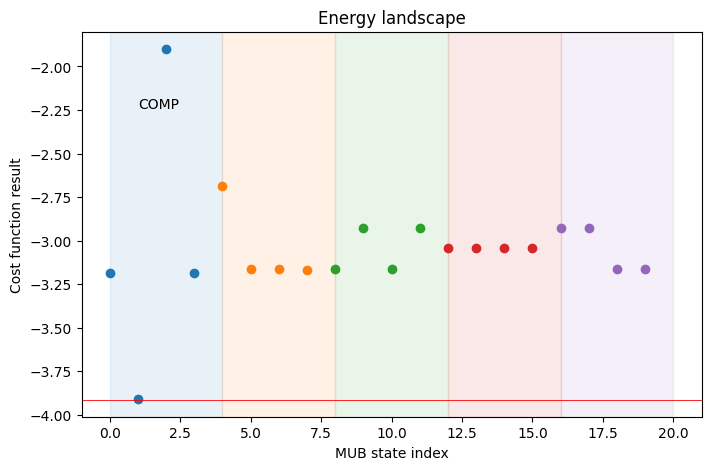

Energy Histogram:


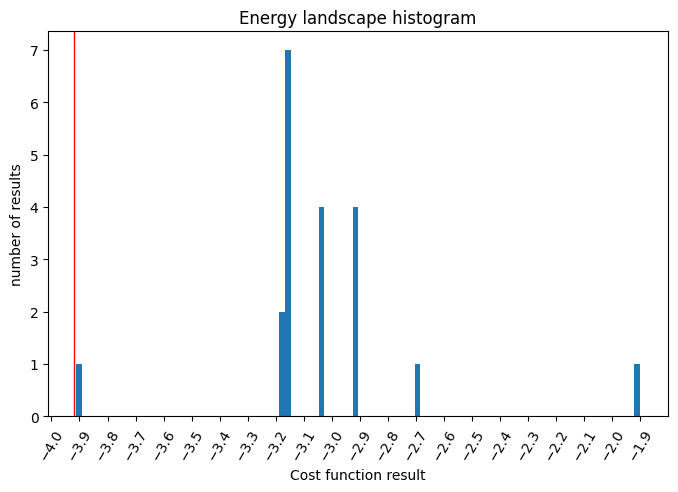

===Calculating Transverse Ising Landscapes===
attempting all MUB states over the operator SparsePauliOp(['ZZ', 'XI', 'IX'],
              coeffs=[0.32383276+0.j, 0.15084917+0.j, 0.15084917+0.j])
Energy Landscape:


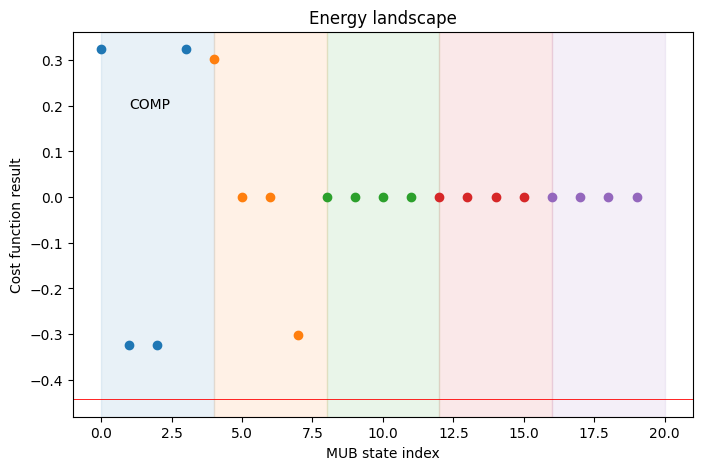

Energy Histogram:


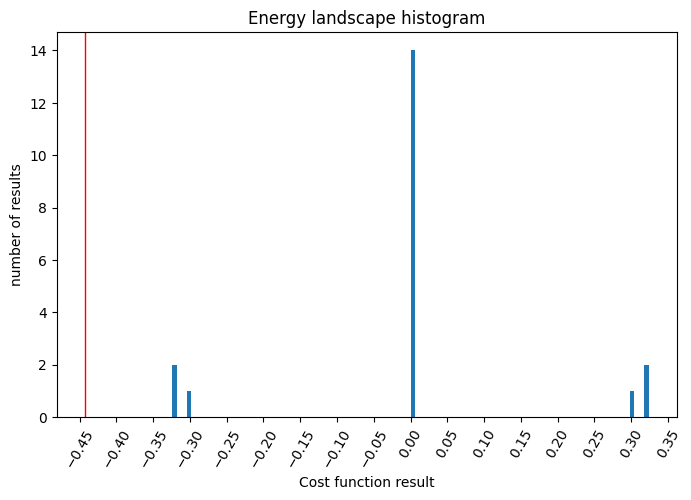

attempting all MUB states over the operator SparsePauliOp(['ZZ', 'XI', 'IX'],
              coeffs=[0.65093447+0.j, 0.07243629+0.j, 0.07243629+0.j])
Energy Landscape:


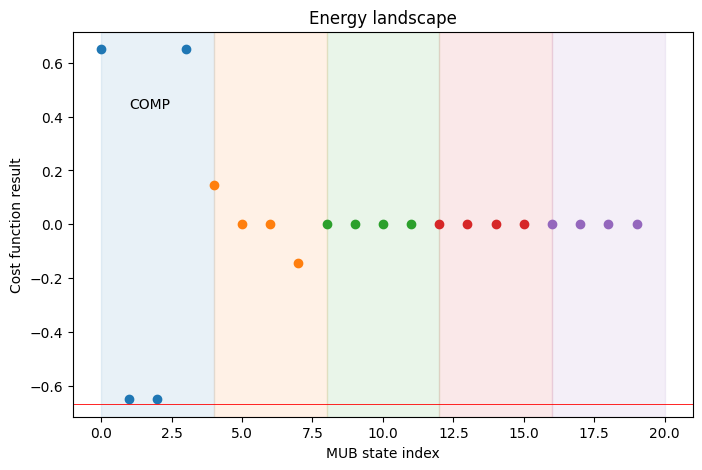

Energy Histogram:


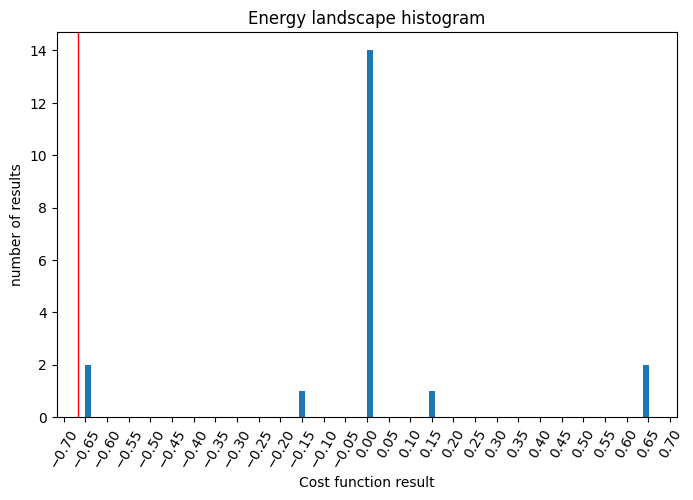

In [4]:
print("===Calculating Molecular Landscapes===")
molecular_landscapes = run_and_record_landscape_list(molecular_hams, n_mub_qubits=2)
print("===Calculating Transverse Ising Landscapes===")
transverse_landscapes = run_and_record_landscape_list(transverse_hams, n_mub_qubits=2)


### VQE Execution

In [6]:
molecular_vqe_runs = run_and_record_vqe_expressive_2q_list(molecular_landscapes, record_progress=True)
transverse_vqe_runs = run_and_record_vqe_expressive_2q_list(transverse_landscapes, record_progress=True)
plot_VQE_evals_list(molecular_vqe_runs, "2-qubit molecular VQE run")
plot_VQE_evals_list(molecular_vqe_runs, "2-qubit transverse-ising VQE run")

The operator SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.06324002+0.j,  0.38913654+0.j, -0.38913654+0.j, -0.01121274+0.j,
  0.18206025+0.j]) has the exact value -1.851311285646772.
Now trying to reach the value from different MUB points.
running from state of index subset 0, MUB 0, state 1 and value -1.83030036
running from state of index subset 0, MUB 1, state 1 and value -1.24530027
running from state of index subset 0, MUB 1, state 2 and value -1.24530027
running from state of index subset 0, MUB 0, state 0 and value -1.07445276
running from state of index subset 0, MUB 0, state 3 and value -1.07445276
The operator SparsePauliOp(['II', 'IZ', 'IX', 'ZI', 'XI', 'ZZ', 'ZX', 'XZ', 'XX'],
              coeffs=[-3.04506092+0.j,  0.50258052+0.j,  0.11926278+0.j, -0.50258052+0.j,
  0.11926278+0.j, -0.13894646+0.j, -0.11926145+0.j,  0.11926145+0.j,
  0.11714671+0.j]) has the exact value -3.9185595435588123.
Now trying to reach the value from different MUB points.
r

NameError: name 'plot_VQE_evals_list' is not defined

## Three-qubit experiments
These experiments are run on two types of examples:
-   Hamiltonian reductions of MAXCUT problem instances.
-   Transverse-Field Ising Model Hamiltonians.

For these, we will present:
-   The energy landscape sampled using all MUB states, with an appended ansatz.
-   VQE execution from the best 10 MUB+ansatz states as initial points.

### Hamiltonian Generation

In [6]:
n_qubits = 3
n_mub_qubits = 3
edges_options =[[(0,1), (1,2), (2,0)],
    [(0,1), (1,2)]]
maxcut_hams = [gen_maxcut_op(n_qubits, edges) for edges in edges_options]
maxcut_exact_results = [get_exact_ground(op) for op in maxcut_hams]

TRANSVERSE_OPS = 3
zz_coeffs = [random.uniform(0,1) for _ in range(TRANSVERSE_OPS)]
x_coeffs = [random.uniform(0,1) for _ in range(TRANSVERSE_OPS)]
transverse_hams = [gen_trans_ising_op(n_qubits, zz_coeff, x_coeff) for zz_coeff, x_coeff in zip(zz_coeffs, x_coeffs)]
transverse_exact_results = [get_exact_ground(op) for op in transverse_hams]
ansatz = get_twolocal(n_qubits, n_qubits)

### Calculate Landscape

===Calculating Maxcut Landscapes===
attempting all MUB states over the operator SparsePauliOp(['IZZ', 'ZIZ', 'ZZI', 'III'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j, -1.5+0.j])
Energy Landscape:


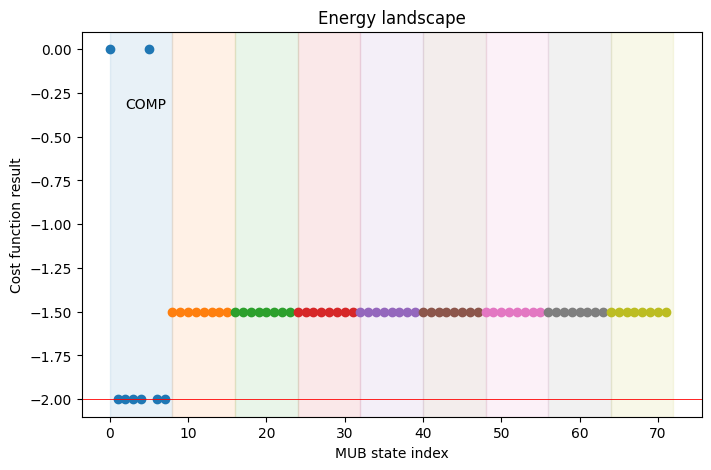

Energy Histogram:


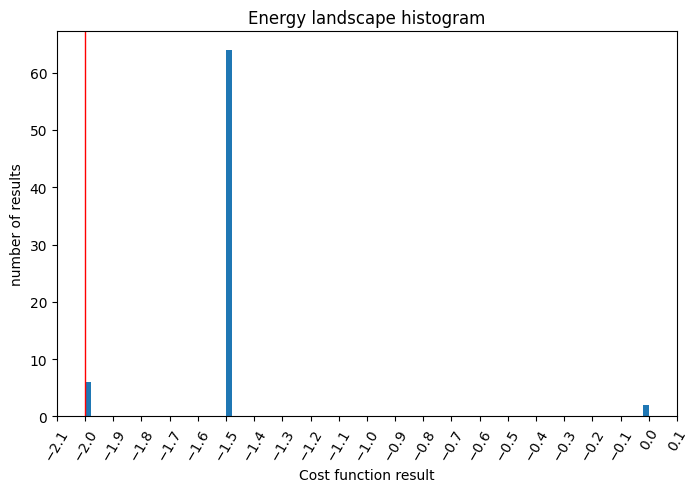

attempting all MUB states over the operator SparsePauliOp(['IZZ', 'ZZI', 'III'],
              coeffs=[ 0.5+0.j,  0.5+0.j, -1. +0.j])
Energy Landscape:


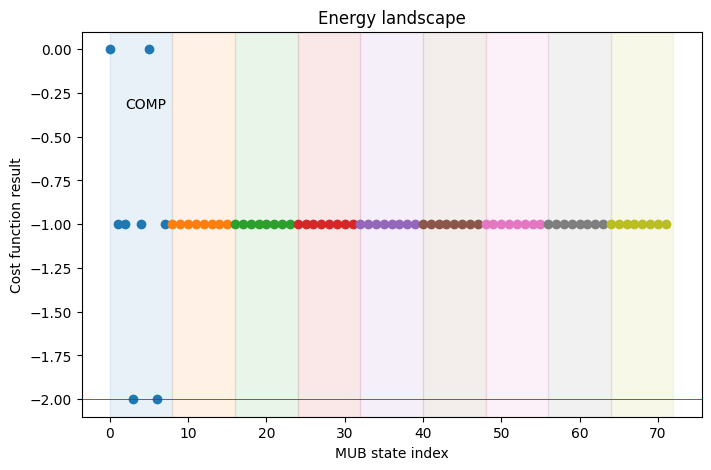

Energy Histogram:


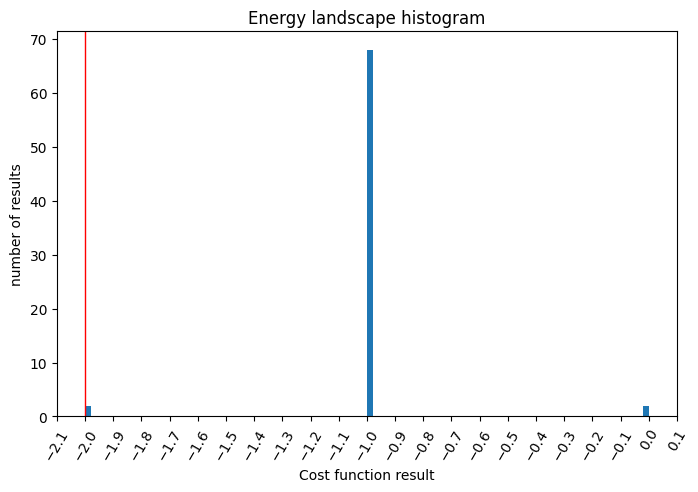

===Calculating Transverse Ising Landscapes===
attempting all MUB states over the operator SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IIX'],
              coeffs=[0.535882  +0.j, 0.535882  +0.j, 0.50743573+0.j, 0.50743573+0.j,
 0.50743573+0.j])
Energy Landscape:


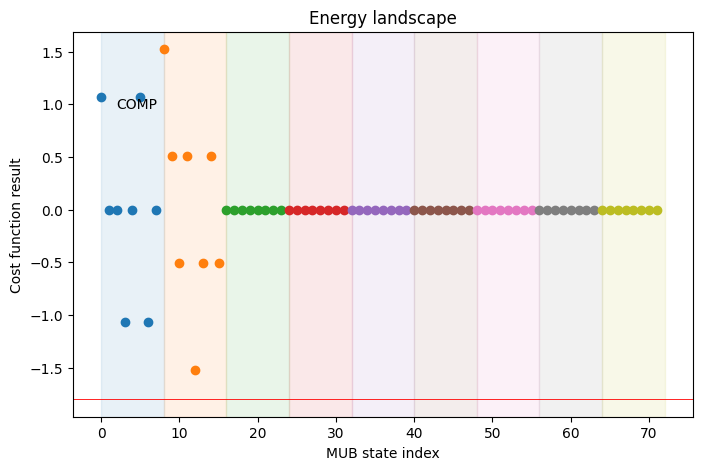

Energy Histogram:


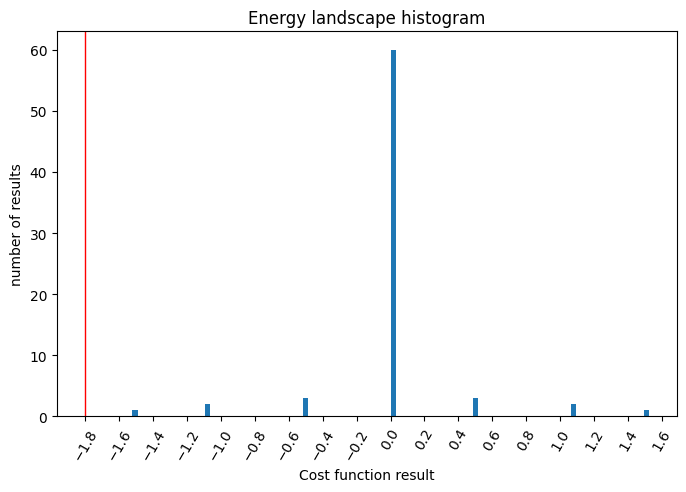

attempting all MUB states over the operator SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IIX'],
              coeffs=[0.36568892+0.j, 0.36568892+0.j, 0.03749566+0.j, 0.03749566+0.j,
 0.03749566+0.j])
Energy Landscape:


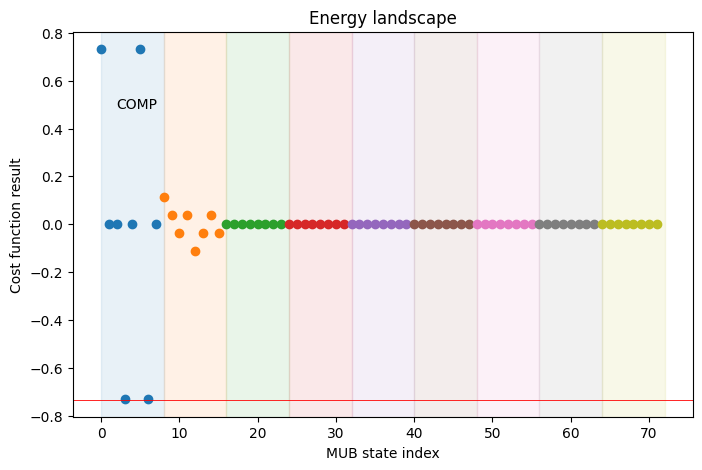

Energy Histogram:


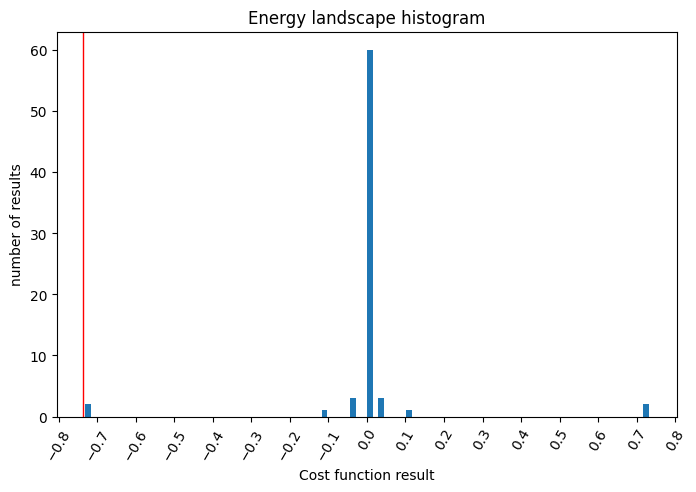

attempting all MUB states over the operator SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IIX'],
              coeffs=[0.05799892+0.j, 0.05799892+0.j, 0.43364568+0.j, 0.43364568+0.j,
 0.43364568+0.j])
Energy Landscape:


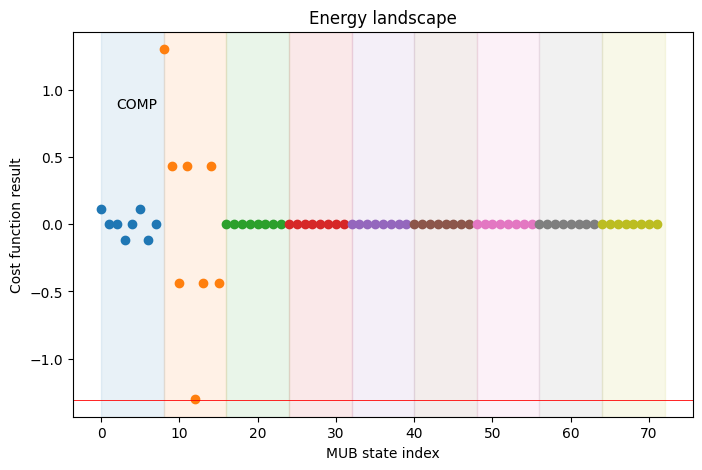

Energy Histogram:


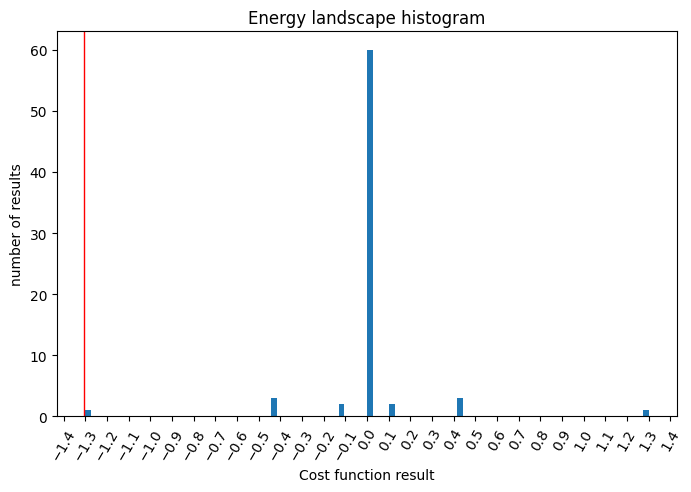

In [7]:

print("===Calculating Maxcut Landscapes===")
maxcut_landscapes = run_and_record_landscape_shifted_list(maxcut_hams, n_mub_qubits=3, ansatz=ansatz)
print("===Calculating Transverse Ising Landscapes===")
transverse_landscapes = run_and_record_landscape_shifted_list(transverse_hams, n_mub_qubits=3, ansatz=ansatz)


### VQE Runs

In [8]:
run_and_record_vqe_shifted_list(maxcut_landscapes, ansatz)
run_and_record_vqe_shifted_list(transverse_landscapes, ansatz)   

The operator SparsePauliOp(['IZZ', 'ZIZ', 'ZZI', 'III'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j, -1.5+0.j]) has the exact value -2.0.
Now trying to reach the vcalue from different MUB points.
running from state of index MUBIndex(subset_idx=0, mub_idx=0, basis_state_idx=1) and value -2.0
(476, -1.9999999999990181, False, [])
running from state of index MUBIndex(subset_idx=0, mub_idx=0, basis_state_idx=2) and value -2.0
(508, -1.99999999999907, False, [])
running from state of index MUBIndex(subset_idx=0, mub_idx=0, basis_state_idx=3) and value -2.0
(509, -1.9999999999991718, False, [])
running from state of index MUBIndex(subset_idx=0, mub_idx=0, basis_state_idx=4) and value -2.0
(476, -1.9999999999987552, False, [])
running from state of index MUBIndex(subset_idx=0, mub_idx=0, basis_state_idx=6) and value -2.0
(508, -1.99999999999923, False, [])
running from state of index MUBIndex(subset_idx=0, mub_idx=0, basis_state_idx=7) and value -2.0
(508, -1.9999999999993125, False, 

## >3 qubit experiments
These experiments are run on two types of examples:
-   Hamiltonian reductions of MAXCUT problem instances.
-   Transverse-Field Ising Model Hamiltonians.
-   **In addition**, the 4-qubit Molecular Hamiltonian will be landscaped here.

For these, we will present:
-   The energy landscape sampled using all partial-MUB states, with an appended ansatz.
-   VQE execution from the best 10 partial-MUB+ansatz states as initial points.

### Hamiltonian Generation

In [4]:
# half-MUB experiments
n_mub_qubits = 3
n_qubits_list = list(range(4,9))

# Transverse Ising Hamiltonians
zz_coeffs = [random.uniform(0,1) for _ in n_qubits_list]
x_coeffs = [random.uniform(0,1) for _ in n_qubits_list]
transverse_ham_params = zip(n_qubits_list, zz_coeffs, x_coeffs)

LiH_ham_1_5 = SparsePauliOp(
    data= ['IIII', 'IIIZ', 'IIZX', 'IIIX', 'IIXX', 'IIYY', 'IIZZ', 'IIXZ', 'IIXI', 'IIZI', 'IZII', 'ZXII', 'IXII', 'XXII', 'YYII',
    'ZZII', 'XZII', 'XIII', 'ZIII', 'IZIZ', 'IZZX', 'IZIX', 'IZXX', 'IZYY', 'ZXIZ', 'IXIZ', 'ZXZX', 'IXZX', 'ZXIX', 'IXIX', 'ZXXX',
    'IXXX', 'ZXYY', 'IXYY', 'XXIZ', 'YYIZ', 'XXZX', 'YYZX', 'XXIX', 'YYIX', 'XXXX', 'YYXX', 'XXYY', 'YYYY', 'ZZIZ', 'ZZZX', 'ZZIX',
    'ZZXX', 'ZZYY', 'XZIZ', 'XIIZ', 'XZZX', 'XIZX', 'XZIX', 'XIIX', 'XZXX', 'XIXX', 'XZYY', 'XIYY', 'ZIIZ', 'ZIZX', 'ZIIX', 'ZIXX',
    'ZIYY', 'IZZZ', 'IZXZ', 'IZXI', 'ZXZZ', 'IXZZ', 'ZXXZ', 'IXXZ', 'ZXXI', 'IXXI', 'XXZZ', 'YYZZ', 'XXXZ', 'YYXZ', 'XXXI', 'YYXI',
    'ZZZZ', 'ZZXZ', 'ZZXI', 'XZZZ', 'XIZZ', 'XZXZ', 'XIXZ', 'XZXI', 'XIXI', 'ZIZZ', 'ZIXZ', 'ZIXI', 'IZZI', 'ZXZI', 'IXZI', 'XXZI',
    'YYZI', 'ZZZI', 'XZZI', 'XIZI', 'ZIZI'], 
coeffs = [-1.99754128e-01+0.j, -9.17966069e-02+0.j, -2.73410751e-03+0.j,
        2.73410751e-03+0.j, -3.09895035e-04+0.j,  3.09895035e-04+0.j,  -2.11959340e-01+0.j,  1.95776538e-02+0.j,  1.95776538e-02+0.j,
        3.71356404e-01+0.j,  9.17966069e-02+0.j,  2.73410751e-03+0.j, 2.73410751e-03+0.j, -3.09895035e-04+0.j,  3.09895035e-04+0.j,
       -2.11959340e-01+0.j, -1.95776538e-02+0.j,  1.95776538e-02+0.j, -3.71356404e-01+0.j, -1.23570872e-01+0.j,  1.17336239e-02+0.j,
       -1.17336239e-02+0.j,  3.30587286e-02+0.j, -3.30587286e-02+0.j, 1.17336239e-02+0.j,  1.17336239e-02+0.j, -3.03465683e-03+0.j,
       -3.03465683e-03+0.j,  3.03465683e-03+0.j,  3.03465683e-03+0.j, -8.37336142e-03+0.j, -8.37336142e-03+0.j,  8.37336142e-03+0.j,
        8.37336142e-03+0.j, -3.30587286e-02+0.j,  3.30587286e-02+0.j, 8.37336142e-03+0.j, -8.37336142e-03+0.j, -8.37336142e-03+0.j,
        8.37336142e-03+0.j,  3.07383272e-02+0.j, -3.07383272e-02+0.j, -3.07383272e-02+0.j,  3.07383272e-02+0.j,  5.66560676e-02+0.j,
        1.54067009e-03+0.j, -1.54067009e-03+0.j,  2.36793690e-03+0.j, -2.36793690e-03+0.j, -1.27339140e-02+0.j,  1.27339140e-02+0.j,
        2.11113767e-03+0.j, -2.11113767e-03+0.j, -2.11113767e-03+0.j, 2.11113767e-03+0.j,  7.76444118e-03+0.j, -7.76444118e-03+0.j,
       -7.76444118e-03+0.j,  7.76444118e-03+0.j,  1.14339547e-01+0.j, -1.05401874e-02+0.j,  1.05401874e-02+0.j, -3.51167704e-02+0.j,
        3.51167704e-02+0.j, -5.66560676e-02+0.j, -1.27339140e-02+0.j, -1.27339140e-02+0.j, -1.54067009e-03+0.j, -1.54067009e-03+0.j,
        2.11113767e-03+0.j,  2.11113767e-03+0.j,  2.11113767e-03+0.j, 2.11113767e-03+0.j,  2.36793690e-03+0.j, -2.36793690e-03+0.j,
       -7.76444118e-03+0.j,  7.76444118e-03+0.j, -7.76444118e-03+0.j, 7.76444118e-03+0.j,  8.47039180e-02+0.j, -9.01204279e-03+0.j,
       -9.01204279e-03+0.j,  9.01204279e-03+0.j, -9.01204279e-03+0.j, -6.57574490e-03+0.j,  6.57574490e-03+0.j, -6.57574490e-03+0.j,
        6.57574490e-03+0.j,  6.05056057e-02+0.j,  1.08894077e-02+0.j, 1.08894077e-02+0.j,  1.14339547e-01+0.j, -1.05401874e-02+0.j,
       -1.05401874e-02+0.j,  3.51167704e-02+0.j, -3.51167704e-02+0.j, -6.05056057e-02+0.j,  1.08894077e-02+0.j, -1.08894077e-02+0.j,
       -1.14091635e-01+0.j]
)
molecular_exact_result = get_exact_ground(LiH_ham_1_5)

transverse_hams = [gen_trans_ising_op(*ham_params) for ham_params in transverse_ham_params]
transverse_exact_results = [get_exact_ground(op) for op in transverse_hams]


# MAXCUT Hamiltonians
rand_graph_4 = nx.gnm_random_graph(4, 5)
rand_graph_5 = nx.gnm_random_graph(5, 9)
rand_graph_6 = nx.gnm_random_graph(6, 12)
rand_graph_7 = nx.gnm_random_graph(7, 12)
rand_graph_8 = nx.gnm_random_graph(8, 14)
graphs = [rand_graph_4, rand_graph_5, rand_graph_6, rand_graph_7, rand_graph_8]
maxcut_hams = [gen_maxcut_op_from_graph(graph) for graph in graphs]
maxcut_exact_results = [get_exact_ground(op) for op in maxcut_hams]

# ansatzes = [TwoLocal(n, ['rx', 'ry', 'rz'], 'cx', 'linear', reps=n, insert_barriers=True).decompose() for n in n_qubits_list]


### Calculate Landscape

===Calculating Molecular Landscapes===
attempting all MUB states over the operator SparsePauliOp(['IIII', 'IIIZ', 'IIZX', 'IIIX', 'IIXX', 'IIYY', 'IIZZ', 'IIXZ', 'IIXI', 'IIZI', 'IZII', 'ZXII', 'IXII', 'XXII', 'YYII', 'ZZII', 'XZII', 'XIII', 'ZIII', 'IZIZ', 'IZZX', 'IZIX', 'IZXX', 'IZYY', 'ZXIZ', 'IXIZ', 'ZXZX', 'IXZX', 'ZXIX', 'IXIX', 'ZXXX', 'IXXX', 'ZXYY', 'IXYY', 'XXIZ', 'YYIZ', 'XXZX', 'YYZX', 'XXIX', 'YYIX', 'XXXX', 'YYXX', 'XXYY', 'YYYY', 'ZZIZ', 'ZZZX', 'ZZIX', 'ZZXX', 'ZZYY', 'XZIZ', 'XIIZ', 'XZZX', 'XIZX', 'XZIX', 'XIIX', 'XZXX', 'XIXX', 'XZYY', 'XIYY', 'ZIIZ', 'ZIZX', 'ZIIX', 'ZIXX', 'ZIYY', 'IZZZ', 'IZXZ', 'IZXI', 'ZXZZ', 'IXZZ', 'ZXXZ', 'IXXZ', 'ZXXI', 'IXXI', 'XXZZ', 'YYZZ', 'XXXZ', 'YYXZ', 'XXXI', 'YYXI', 'ZZZZ', 'ZZXZ', 'ZZXI', 'XZZZ', 'XIZZ', 'XZXZ', 'XIXZ', 'XZXI', 'XIXI', 'ZIZZ', 'ZIXZ', 'ZIXI', 'IZZI', 'ZXZI', 'IXZI', 'XXZI', 'YYZI', 'ZZZI', 'XZZI', 'XIZI', 'ZIZI'],
              coeffs=[-1.99754128e-01+0.j, -9.17966069e-02+0.j, -2.73410751e-03+0.j,
  2.73410751e-03

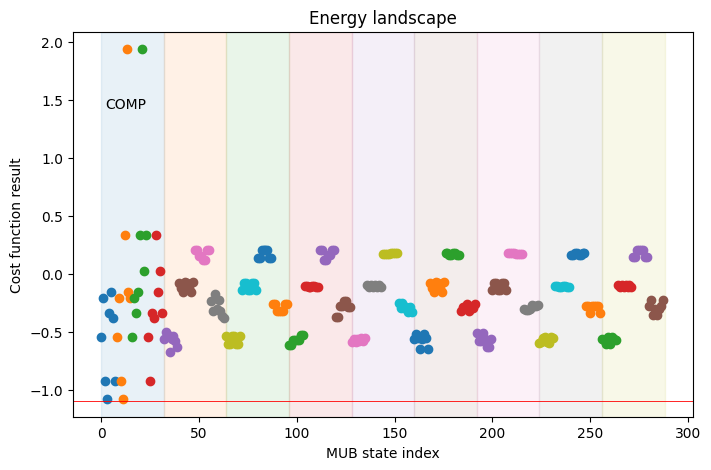

Energy Histogram:


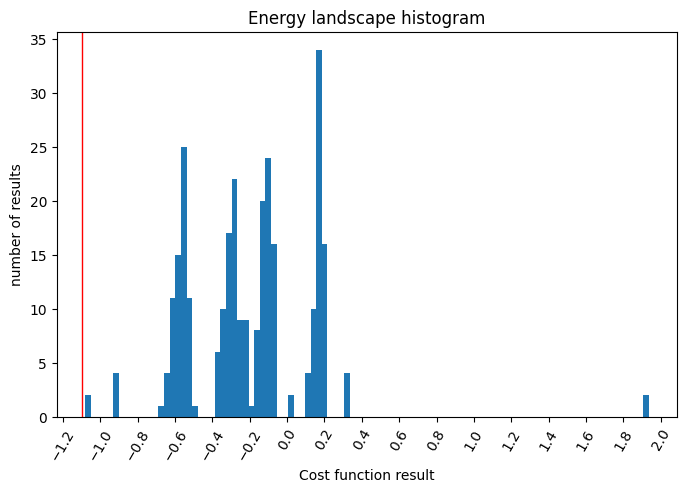

===Calculating Transverse Landscapes===
attempting all MUB states over the operator SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[0.535882  +0.j, 0.535882  +0.j, 0.535882  +0.j, 0.43364568+0.j,
 0.43364568+0.j, 0.43364568+0.j, 0.43364568+0.j])
Energy Landscape:


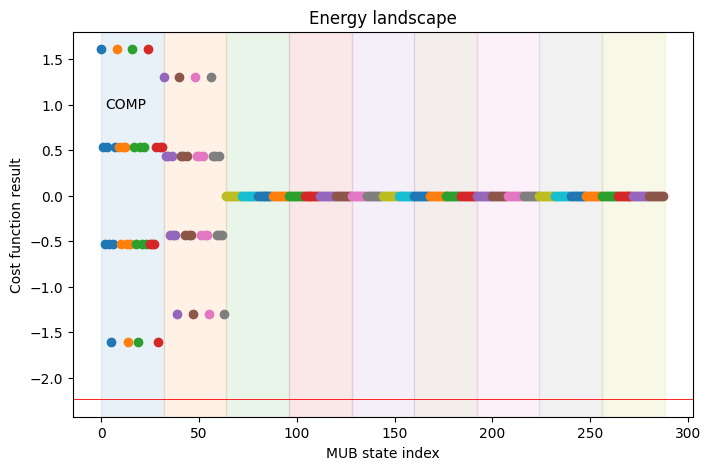

Energy Histogram:


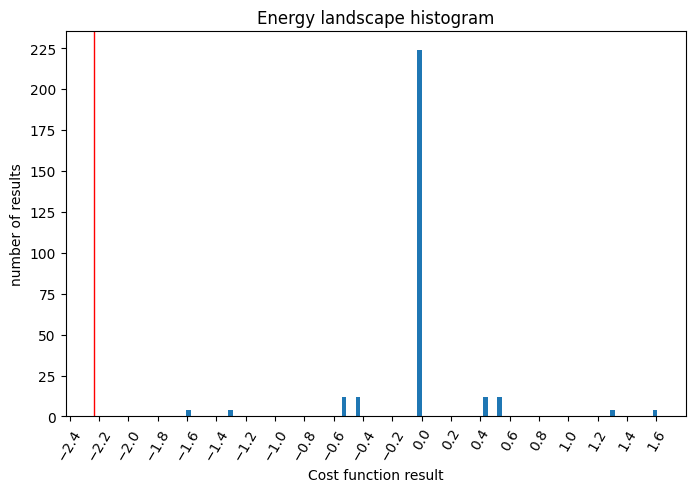

attempting all MUB states over the operator SparsePauliOp(['ZZIII', 'IZZII', 'IIZZI', 'IIIZZ', 'XIIII', 'IXIII', 'IIXII', 'IIIXI', 'IIIIX'],
              coeffs=[0.36568892+0.j, 0.36568892+0.j, 0.36568892+0.j, 0.36568892+0.j,
 0.06985542+0.j, 0.06985542+0.j, 0.06985542+0.j, 0.06985542+0.j,
 0.06985542+0.j])
Energy Landscape:


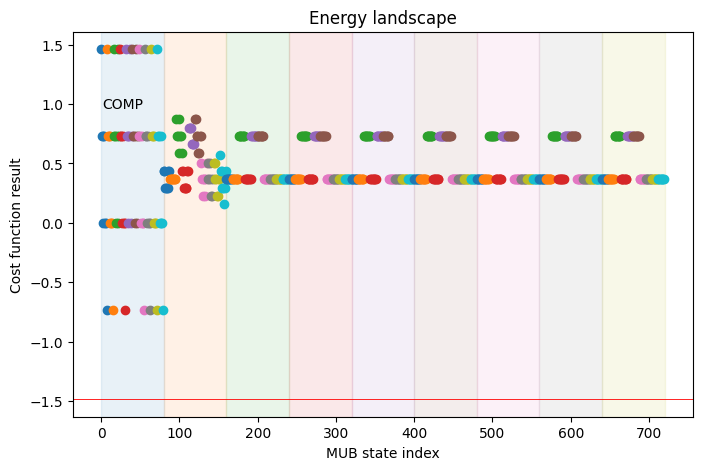

Energy Histogram:


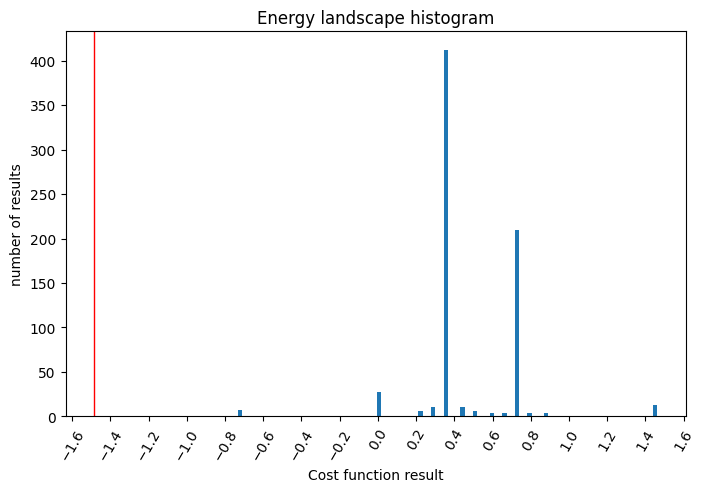

attempting all MUB states over the operator SparsePauliOp(['ZZIIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ', 'XIIIII', 'IXIIII', 'IIXIII', 'IIIXII', 'IIIIXI', 'IIIIIX'],
              coeffs=[0.05799892+0.j, 0.05799892+0.j, 0.05799892+0.j, 0.05799892+0.j,
 0.05799892+0.j, 0.09071301+0.j, 0.09071301+0.j, 0.09071301+0.j,
 0.09071301+0.j, 0.09071301+0.j, 0.09071301+0.j])
Energy Landscape:


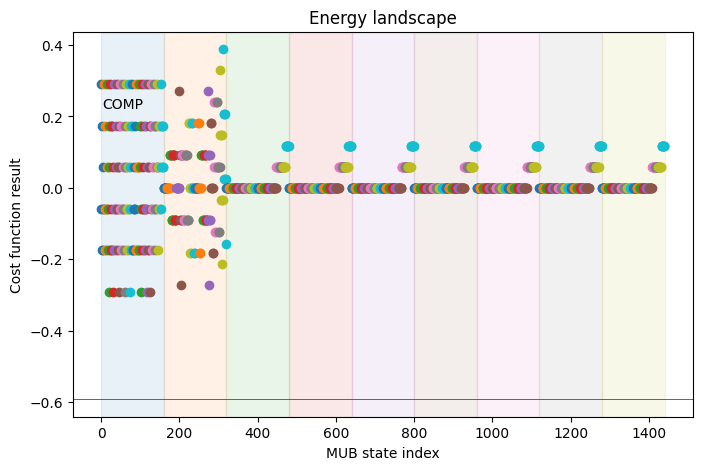

Energy Histogram:


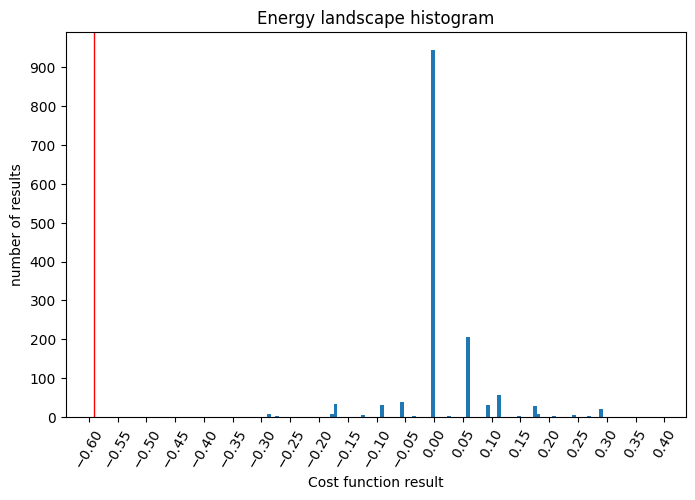

attempting all MUB states over the operator SparsePauliOp(['ZZIIIII', 'IZZIIII', 'IIZZIII', 'IIIZZII', 'IIIIZZI', 'IIIIIZZ', 'XIIIIII', 'IXIIIII', 'IIXIIII', 'IIIXIII', 'IIIIXII', 'IIIIIXI', 'IIIIIIX'],
              coeffs=[0.50743573+0.j, 0.50743573+0.j, 0.50743573+0.j, 0.50743573+0.j,
 0.50743573+0.j, 0.50743573+0.j, 0.42451919+0.j, 0.42451919+0.j,
 0.42451919+0.j, 0.42451919+0.j, 0.42451919+0.j, 0.42451919+0.j,
 0.42451919+0.j])
Energy Landscape:


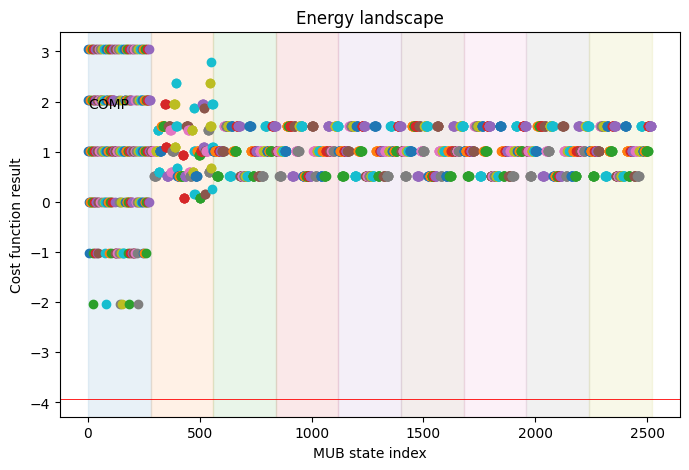

Energy Histogram:


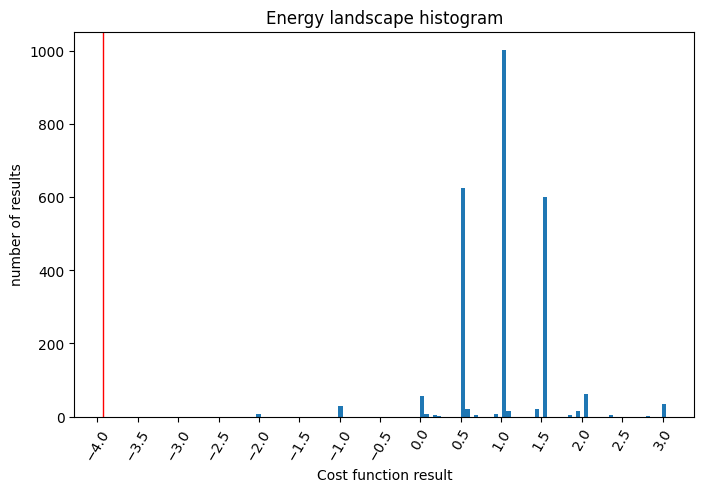

attempting all MUB states over the operator SparsePauliOp(['ZZIIIIII', 'IZZIIIII', 'IIZZIIII', 'IIIZZIII', 'IIIIZZII', 'IIIIIZZI', 'IIIIIIZZ', 'XIIIIIII', 'IXIIIIII', 'IIXIIIII', 'IIIXIIII', 'IIIIXIII', 'IIIIIXII', 'IIIIIIXI', 'IIIIIIIX'],
              coeffs=[0.03749566+0.j, 0.03749566+0.j, 0.03749566+0.j, 0.03749566+0.j,
 0.03749566+0.j, 0.03749566+0.j, 0.03749566+0.j, 0.82685212+0.j,
 0.82685212+0.j, 0.82685212+0.j, 0.82685212+0.j, 0.82685212+0.j,
 0.82685212+0.j, 0.82685212+0.j, 0.82685212+0.j])
Energy Landscape:


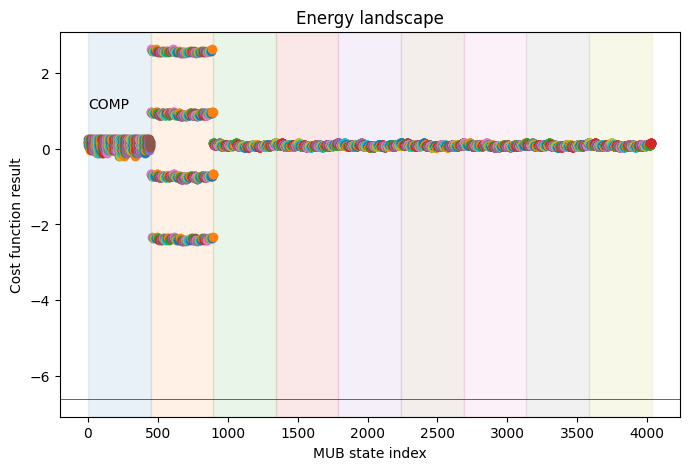

Energy Histogram:


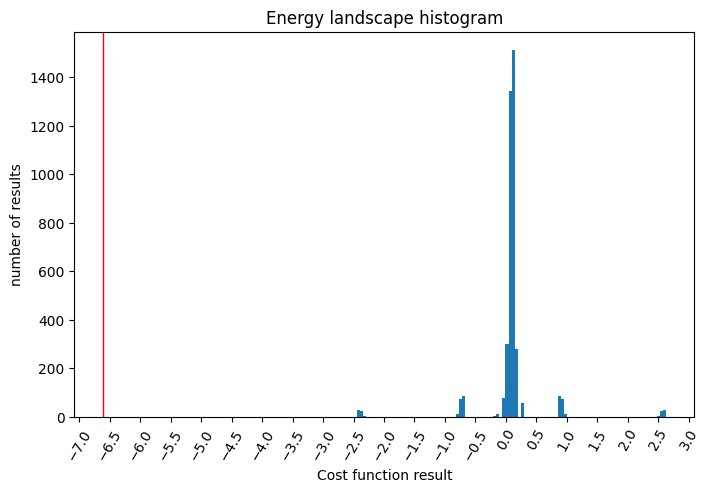

===Calculating Maxcut Landscapes===
attempting all MUB states over the operator SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZZII', 'IIII'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j, -2.5+0.j])
Energy Landscape:


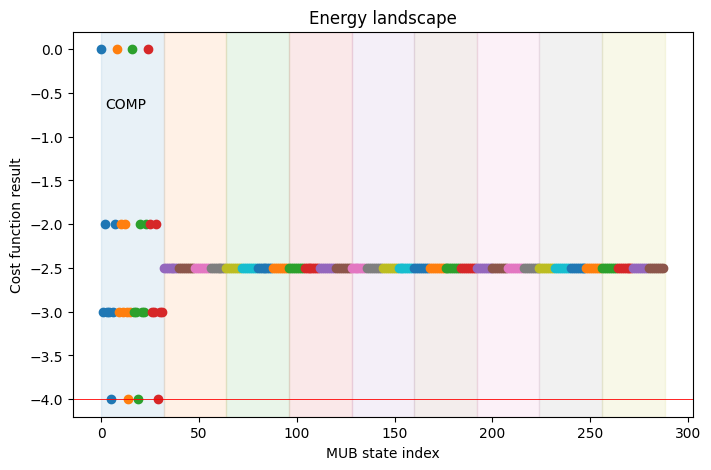

Energy Histogram:


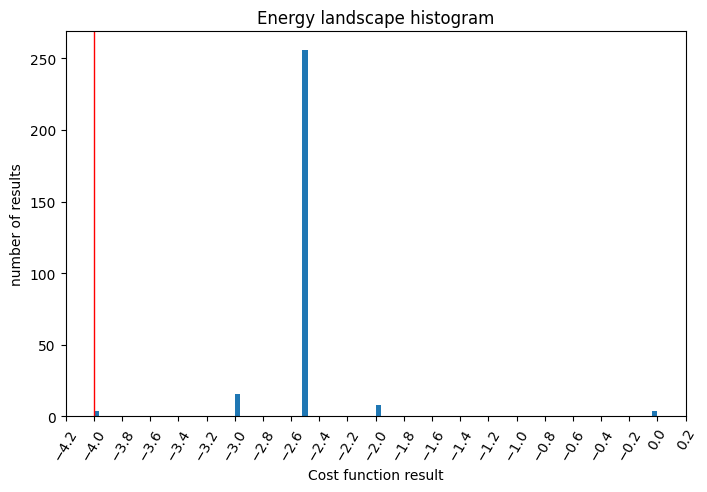

attempting all MUB states over the operator SparsePauliOp(['IIZIZ', 'IZIIZ', 'ZIIIZ', 'IIZZI', 'IZIZI', 'ZIIZI', 'IZZII', 'ZIZII', 'ZZIII', 'IIIII'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j, -4.5+0.j])
Energy Landscape:


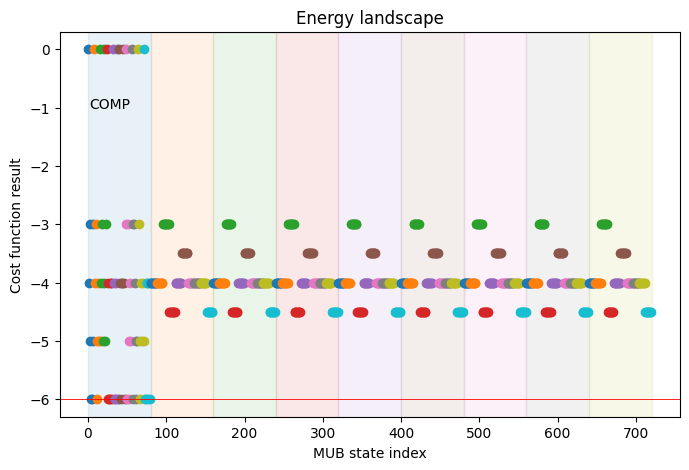

Energy Histogram:


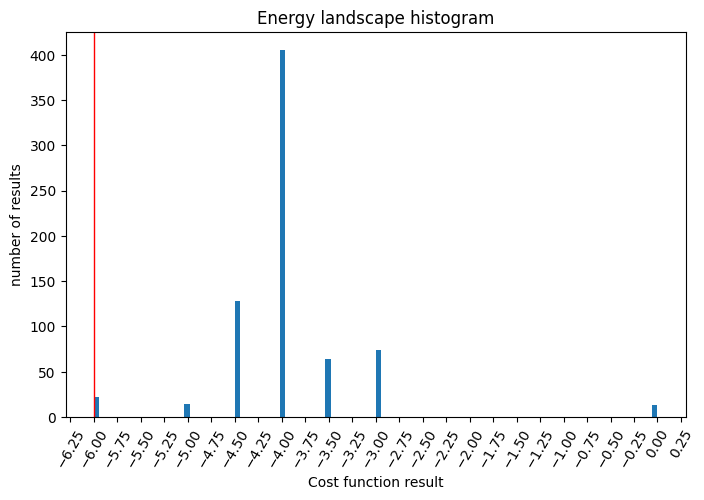

attempting all MUB states over the operator SparsePauliOp(['IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'ZIIIIZ', 'IIIZZI', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IIZZII', 'ZIIZII', 'ZIZIII', 'ZZIIII', 'IIIIII'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j, -6. +0.j])
Energy Landscape:


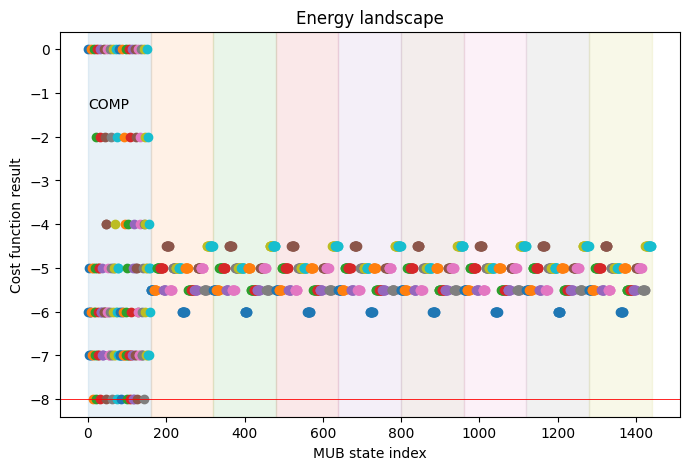

Energy Histogram:


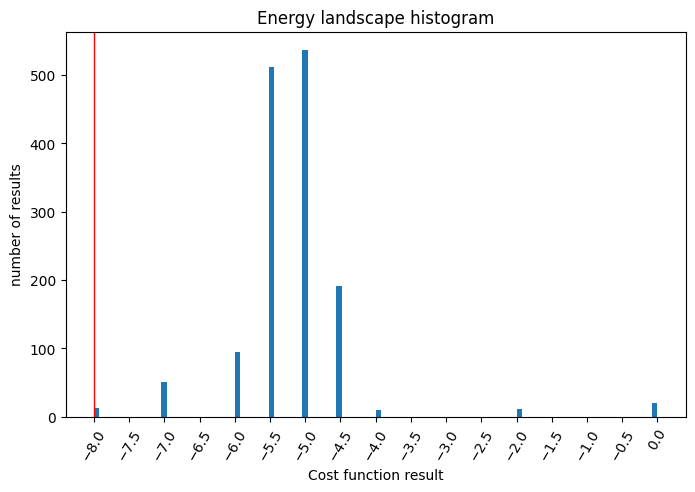

attempting all MUB states over the operator SparsePauliOp(['IIIIIZZ', 'IIIIZIZ', 'IIIZIIZ', 'IIIIZZI', 'IIIZIZI', 'IZIIIZI', 'IIIZZII', 'IZIIZII', 'IIZZIII', 'IZIZIII', 'ZIIZIII', 'ZIZIIII', 'IIIIIII'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j, -6. +0.j])
Energy Landscape:


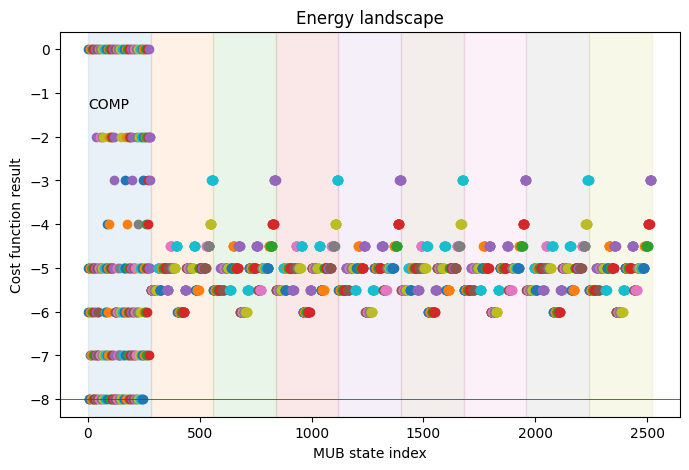

Energy Histogram:


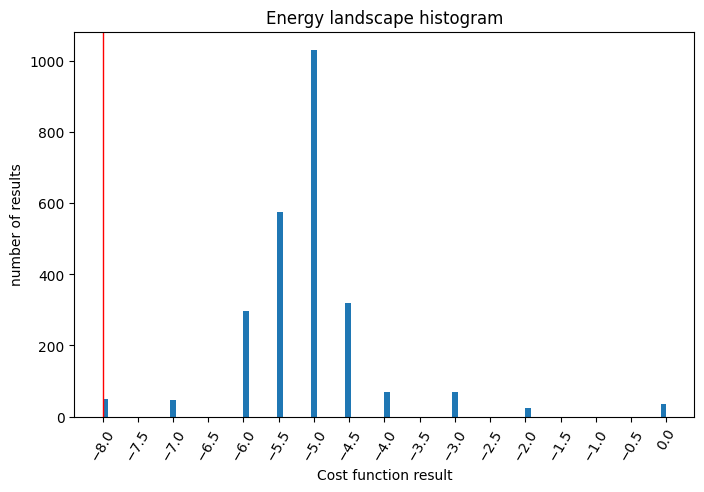

attempting all MUB states over the operator SparsePauliOp(['IIIIIIZZ', 'IIIIIZIZ', 'IIIIZIIZ', 'IIIIIZZI', 'IIIIZIZI', 'IIZIIIZI', 'IZIIIIZI', 'ZIIIIIZI', 'IIIZIZII', 'ZIIIIZII', 'IIZIZIII', 'IZIIZIII', 'ZIIZIIII', 'ZZIIIIII', 'IIIIIIII'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
 -7. +0.j])
Energy Landscape:


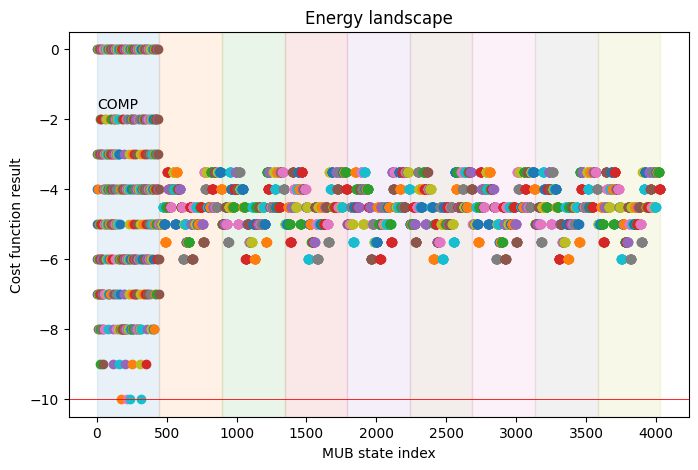

Energy Histogram:


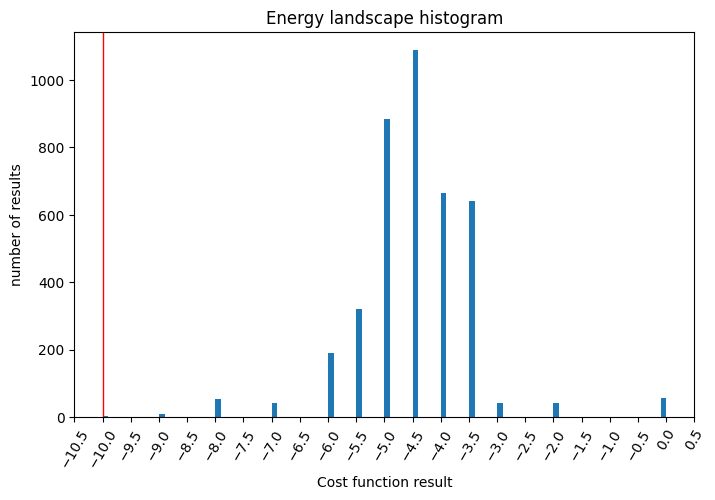

In [5]:
print("===Calculating Molecular Landscapes===")
n_qubits = LiH_ham_1_5.num_qubits 
ansatz = get_twolocal(n_qubits, n_qubits)
LiH_landscape = run_and_record_landscape_shifted(LiH_ham_1_5, n_mub_qubits, ansatz)

print("===Calculating Transverse Landscapes===")
transverse_landscapes = []
for n_qubits, ham in zip(n_qubits_list, transverse_hams):
    ansatz = get_twolocal(n_qubits, n_qubits)
    transverse_landscapes.append(run_and_record_landscape_shifted(ham, n_mub_qubits, ansatz))

print("===Calculating Maxcut Landscapes===")
maxcut_landscapes = []
for n_qubits, ham in zip(n_qubits_list, maxcut_hams):
    ansatz = get_twolocal(n_qubits, n_qubits)
    maxcut_landscapes.append(run_and_record_landscape_shifted(ham, n_mub_qubits, ansatz))

### VQE Runs

In [6]:
n_qubits = LiH_ham_1_5.num_qubits
ansatz = get_twolocal(n_qubits, n_qubits) 
run_and_record_vqe_shifted(LiH_landscape, ansatz)

The operator SparsePauliOp(['IIII', 'IIIZ', 'IIZX', 'IIIX', 'IIXX', 'IIYY', 'IIZZ', 'IIXZ', 'IIXI', 'IIZI', 'IZII', 'ZXII', 'IXII', 'XXII', 'YYII', 'ZZII', 'XZII', 'XIII', 'ZIII', 'IZIZ', 'IZZX', 'IZIX', 'IZXX', 'IZYY', 'ZXIZ', 'IXIZ', 'ZXZX', 'IXZX', 'ZXIX', 'IXIX', 'ZXXX', 'IXXX', 'ZXYY', 'IXYY', 'XXIZ', 'YYIZ', 'XXZX', 'YYZX', 'XXIX', 'YYIX', 'XXXX', 'YYXX', 'XXYY', 'YYYY', 'ZZIZ', 'ZZZX', 'ZZIX', 'ZZXX', 'ZZYY', 'XZIZ', 'XIIZ', 'XZZX', 'XIZX', 'XZIX', 'XIIX', 'XZXX', 'XIXX', 'XZYY', 'XIYY', 'ZIIZ', 'ZIZX', 'ZIIX', 'ZIXX', 'ZIYY', 'IZZZ', 'IZXZ', 'IZXI', 'ZXZZ', 'IXZZ', 'ZXXZ', 'IXXZ', 'ZXXI', 'IXXI', 'XXZZ', 'YYZZ', 'XXXZ', 'YYXZ', 'XXXI', 'YYXI', 'ZZZZ', 'ZZXZ', 'ZZXI', 'XZZZ', 'XIZZ', 'XZXZ', 'XIXZ', 'XZXI', 'XIXI', 'ZIZZ', 'ZIXZ', 'ZIXI', 'IZZI', 'ZXZI', 'IXZI', 'XXZI', 'YYZI', 'ZZZI', 'XZZI', 'XIZI', 'ZIZI'],
              coeffs=[-1.99754128e-01+0.j, -9.17966069e-02+0.j, -2.73410751e-03+0.j,
  2.73410751e-03+0.j, -3.09895035e-04+0.j,  3.09895035e-04+0.j,
 -2.11959340e-01+0.j, 

In [11]:


print("===Performing Transverse-Ising VQE===")
for n_qubits, landscape in zip(n_qubits_list, transverse_landscapes):
    ansatz = get_twolocal(n_qubits, n_qubits)   
    run_and_record_vqe_shifted(landscape, ansatz)


print("===Performing MAXCUT VQE===")
for n_qubits, landscape in zip(n_qubits_list, maxcut_landscapes):
    ansatz = get_twolocal(n_qubits, n_qubits)
    run_and_record_vqe_shifted(landscape, ansatz)

===Performing Transverse-Ising VQE===
The operator SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[0.06985542+0.j, 0.06985542+0.j, 0.06985542+0.j, 0.22323896+0.j,
 0.22323896+0.j, 0.22323896+0.j, 0.22323896+0.j]) has the exact value -0.9093826415823253.
Now trying to reach the vcalue from different MUB points.
running from state of index MUBIndex(subset_idx=0, mub_idx=1, basis_state_idx=7) and value -0.6697168938
(4000, -0.9092992533050245, False, [])
running from state of index MUBIndex(subset_idx=1, mub_idx=1, basis_state_idx=7) and value -0.6697168938
(4000, -0.9093106435415026, False, [])
running from state of index MUBIndex(subset_idx=2, mub_idx=1, basis_state_idx=7) and value -0.6697168938
(4000, -0.90938086373897, False, [])
running from state of index MUBIndex(subset_idx=3, mub_idx=1, basis_state_idx=7) and value -0.6697168938
(4000, -0.9093814756336493, False, [])
running from state of index MUBIndex(subset_idx=0, mub_idx=1, basis_

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10689acc0>>
Traceback (most recent call last):
  File "/Users/ittay/venvs/quantum/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
